# Q1

#### Step 1 Data Loading and Cleaning 

In [295]:
import requests
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [296]:
# Download required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\radha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\radha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\radha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\radha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\radha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
urls = [
    'https://www.gutenberg.org/cache/epub/84/pg84.txt',     # Frankenstein
    'https://www.gutenberg.org/cache/epub/1661/pg1661.txt',  # Sherlock Holmes
    'https://www.gutenberg.org/cache/epub/2701/pg2701.txt'   # Moby Dick
]

texts = []
for url in urls:
    response = requests.get(url)
    texts.append(response.text)

# Concatenate all novels into one big corpus
raw_text = ' '.join(texts)

print(f"Total characters in concatenated corpus: {len(raw_text)}")

Total characters in concatenated corpus: 2300956


In [299]:
# Normalize whitespace and lowercase
text = re.sub(r'\s+', ' ', text)
text = text.lower()

In [300]:
# Sentence tokenization
sentences = nltk.sent_tokenize(text)
print(f" Total sentences: {len(sentences)}")

 Total sentences: 1093


In [301]:
# Light clean each sentence
cleaned_sentences = []
for sent in sentences:
    sent = re.sub(r'[^a-zA-Z\s]', '', sent)
    if len(sent.split()) > 3:  # keep meaningful sentences
        cleaned_sentences.append(sent.strip())

# Join cleaned corpus
cleaned_corpus = ' '.join(cleaned_sentences)
print(f" Total cleaned characters: {len(cleaned_corpus)}")

 Total cleaned characters: 152344


In [302]:
# Join cleaned sentences into a corpus
cleaned_corpus = ' '.join(cleaned_sentences)
print(f" Length of cleaned_corpus: {len(cleaned_corpus)}")
print(f" Preview of cleaned_corpus: {cleaned_corpus[:200]}")

 Length of cleaned_corpus: 152344
 Preview of cleaned_corpus: the project gutenberg ebook of alices adventures in wonderland this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restric


### Step 2: Select 100 Meaningful Words from the Cleaned Text 

In [303]:
from collections import Counter
#Tokenize the corpus
tokens = nltk.word_tokenize(cleaned_corpus)
print(f" Total tokens: {len(tokens)}")


 Total tokens: 29368


In [304]:
# POS tagging
tagged = nltk.pos_tag(tokens)
print(f"Sample tagged tokens: {tagged[:10]}")

Sample tagged tokens: [('the', 'DT'), ('project', 'NN'), ('gutenberg', 'JJ'), ('ebook', 'NN'), ('of', 'IN'), ('alices', 'NNS'), ('adventures', 'NNS'), ('in', 'IN'), ('wonderland', 'NN'), ('this', 'DT')]


In [305]:
# Filter for content words (nouns,adjectives,verbs, adverbs)
def is_content_word(tag):
    return tag.startswith('N') or tag.startswith('V') or tag.startswith('J') or tag.startswith('R')

content_words = [word for word, tag in tagged if is_content_word(tag)]
print(f" Sample content words: {content_words[:10]}")
print(f" Total content words: {len(content_words)}")

 Sample content words: ['project', 'gutenberg', 'ebook', 'alices', 'adventures', 'wonderland', 'ebook', 'is', 'use', 'anyone']
 Total content words: 16678


In [306]:
# Count frequency of content words
word_freq = Counter(content_words)

In [307]:
# Select top 100 most frequent content words
top_100_words = [word for word, _ in word_freq.most_common(100)]

In [308]:
# Create sorted final list L
word_list = sorted(set(top_100_words))

In [309]:
# Output
print(f"Top 10 words from List L: {word_list[:10]}")
print(f" Total content words selected: {len(word_list)}")

Top 10 words from List L: ['again', 'alice', 'are', 'as', 'back', 'be', 'been', 'began', 'came', 'cat']
 Total content words selected: 100


### STEP 3 – Calculate Word Distances via Co-occurrence in Sentences 

In [310]:
import numpy as np
from collections import defaultdict

In [311]:
# Build co-occurrence matrix
co_occurrence = defaultdict(lambda: defaultdict(int))

for sentence in cleaned_sentences:
    words_in_sentence = set(nltk.word_tokenize(sentence))
    for w1 in word_list:
        if w1 in words_in_sentence:
            for w2 in word_list:
                if w1 != w2 and w2 in words_in_sentence:
                    co_occurrence[w1][w2] += 1


In [312]:
# Convert to 2D numpy matrix
size = len(word_list)
similarity_matrix = np.zeros((size, size))

for i, w1 in enumerate(word_list):
    for j, w2 in enumerate(word_list):
        if w1 != w2:
            similarity_matrix[i][j] = co_occurrence[w1][w2]


In [313]:
# Convert similarity to distance (avoid division by zero)
distance_matrix = 1 / (similarity_matrix + 1e-5)  # smaller value = higher similarity

In [314]:
#Replace diagonal with zeros
np.fill_diagonal(distance_matrix, 0)

In [315]:
# Preview
print(" Distance between 'alice' and 'rabbit':", 
      distance_matrix[word_list.index('alice')][word_list.index('rabbit')] 
      if 'alice' in word_list and 'rabbit' in word_list else "One of the words missing.")

print(" Distance matrix shape:", distance_matrix.shape)

 Distance between 'alice' and 'rabbit': 0.06249996093752441
 Distance matrix shape: (100, 100)


### Step 4: Clustering Words Using Distance Matrix 

In [316]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [317]:
#Compute hierarchical linkage
linked = linkage(distance_matrix, method='ward')

C:\Users\radha\AppData\Local\Temp\ipykernel_15500\1950512725.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='ward')


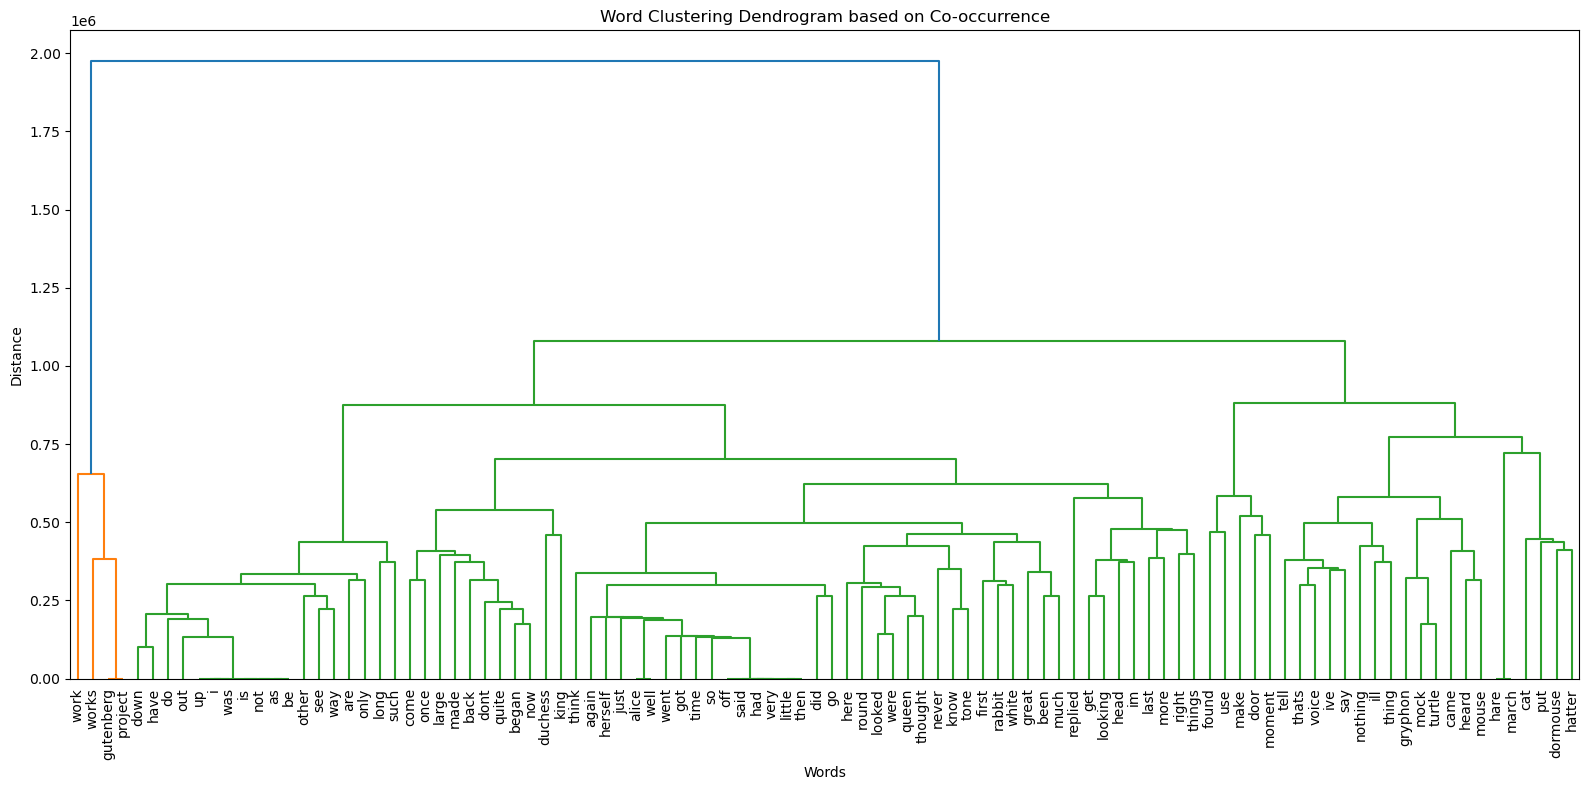

In [318]:
# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linked,
           orientation='top',
           labels=word_list,
           leaf_rotation=90,
           leaf_font_size=10)
plt.title("Word Clustering Dendrogram based on Co-occurrence")
plt.xlabel("Words")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


### Step 5: Dijkstra’s Algorithm for Shortest Path Distances 

In [319]:
import networkx as nx

In [320]:
#  Create a graph
G = nx.Graph()

In [321]:
# Add weighted edges from co-occurrence
for i, w1 in enumerate(word_list):
    for j, w2 in enumerate(word_list):
        if w1 != w2:
            weight = similarity_matrix[i][j]
            if weight > 0:
                # Lower weight = closer relationship
                G.add_edge(w1, w2, weight=1 / weight)

In [322]:
# Initialize Dijkstra distance matrix
dijkstra_matrix = np.zeros((len(word_list), len(word_list)))


In [323]:
#  Use NetworkX's Dijkstra for all word pairs......
for i, w1 in enumerate(word_list):
    lengths = nx.single_source_dijkstra_path_length(G, w1)
    for j, w2 in enumerate(word_list):
        dijkstra_matrix[i][j] = lengths.get(w2, np.inf) 

In [324]:
#  Replace infs with max distance + 1 for consistency
max_val = np.max(dijkstra_matrix[np.isfinite(dijkstra_matrix)])
dijkstra_matrix[~np.isfinite(dijkstra_matrix)] = max_val + 1

print("Dijkstra distance matrix ready. Shape:", dijkstra_matrix.shape)


Dijkstra distance matrix ready. Shape: (100, 100)


### Step 6: Re-cluster using Dijkstra distances 

In [325]:
# Linkage using Dijkstra distances
linked_dijkstra = linkage(dijkstra_matrix, method='ward')

C:\Users\radha\AppData\Local\Temp\ipykernel_15500\3147611880.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked_dijkstra = linkage(dijkstra_matrix, method='ward')


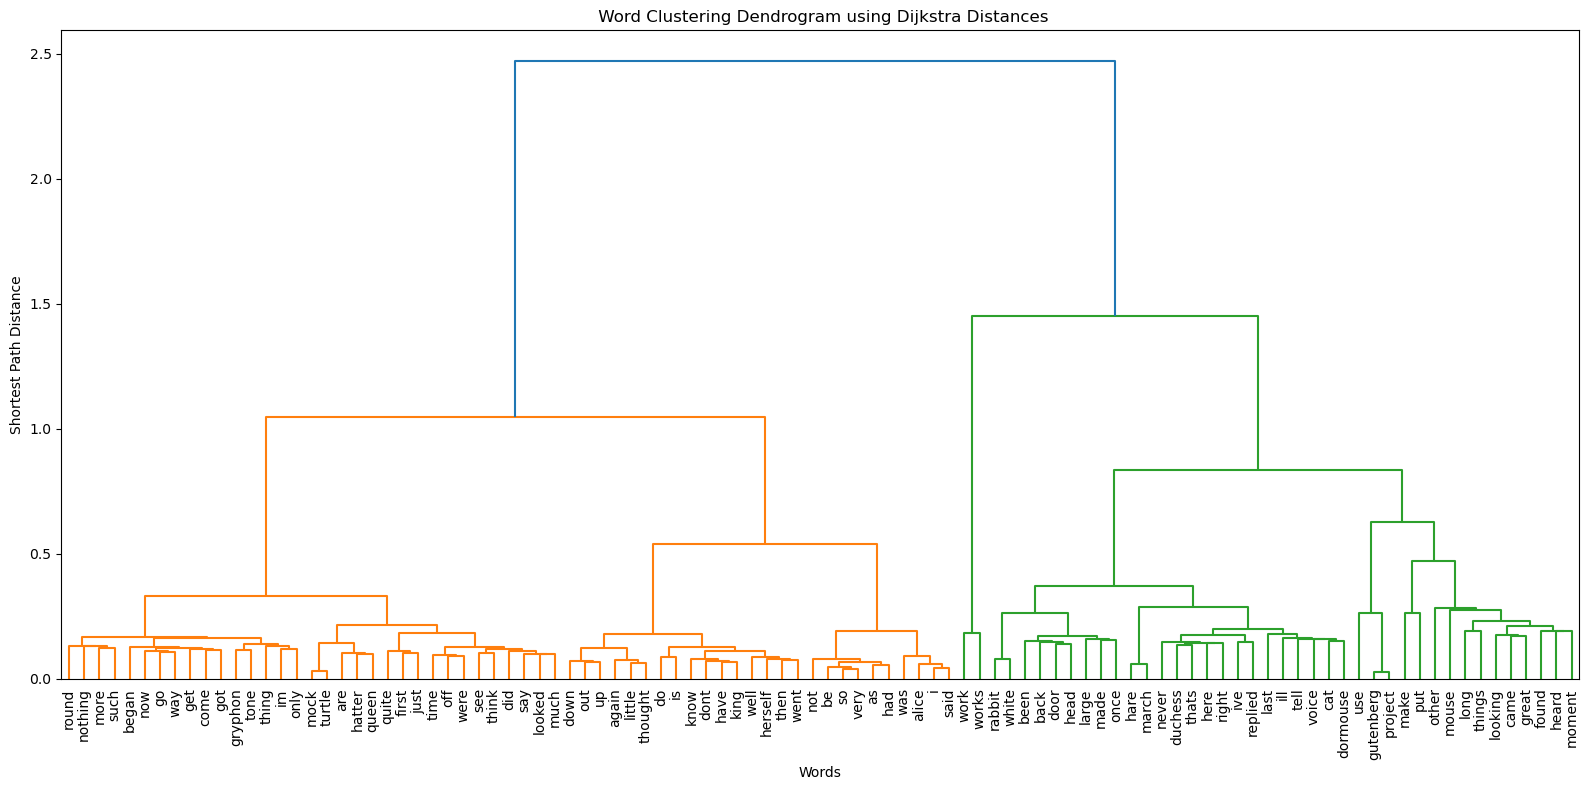

In [326]:
#  Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linked_dijkstra,
           orientation='top',
           labels=word_list,
           leaf_rotation=90,
           leaf_font_size=10)
plt.title(" Word Clustering Dendrogram using Dijkstra Distances")
plt.xlabel("Words")
plt.ylabel("Shortest Path Distance")
plt.tight_layout()
plt.show()


# Q2

In [327]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

In [328]:
# Function to generate data with curved decision boundary
def generate_data(a=0.5, n=500, imbalance=False, seed=42):
    np.random.seed(seed)
    x = np.random.uniform(-2, 2, n)
    y = np.random.uniform(-2, 2, n)
    boundary = a * x**2 + x

    labels = y > boundary
    if imbalance:
        # Flip some labels to create imbalance (e.g. more class 0)
        labels[:int(n * 0.3)] = 0

    X = np.column_stack((x, y))
    y = labels.astype(int)

    return X, y

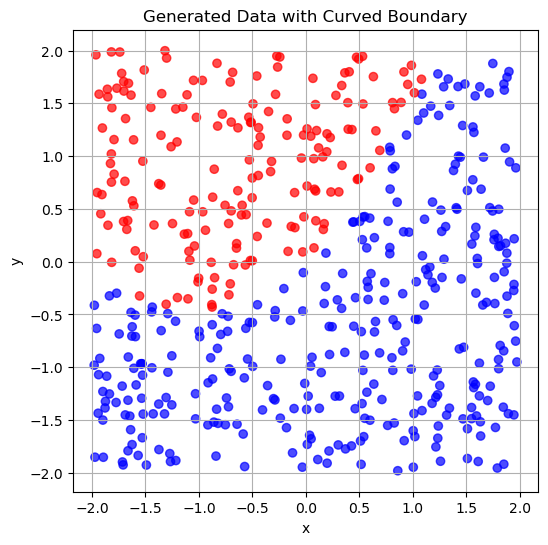

In [329]:
X, y = generate_data(a=0.5, n=500)
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title("Generated Data with Curved Boundary")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

 ### Step 2: Train and Evaluate Logistic Regression

In [330]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [331]:
# Train Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [332]:
# Predict
y_pred = lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f" Logistic Regression Accuracy: {acc:.2f}")


 Logistic Regression Accuracy: 0.89


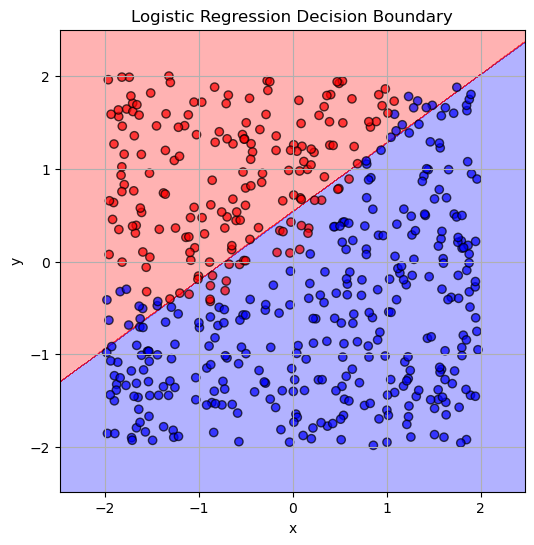

In [333]:
# Visualize decision boundary
h = 0.01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'red']))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', alpha=0.7)
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

### Step 3: Neural Network Classification

In [334]:
from sklearn.neural_network import MLPClassifier

In [335]:
# Build a simple neural network (1 hidden layer with 10 neurons)
nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
nn.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)

In [336]:
# Predict and evaluate
y_pred_nn = nn.predict(X_test)
acc_nn = accuracy_score(y_test, y_pred_nn)
print(f" Neural Network Accuracy: {acc_nn:.2f}")

 Neural Network Accuracy: 0.98


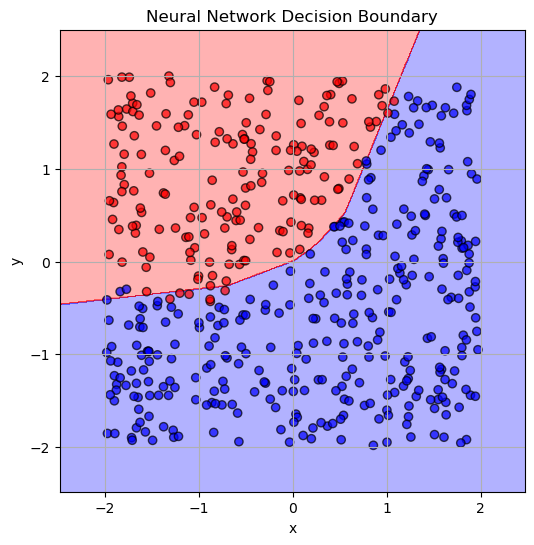

In [337]:
# Plot decision boundary
Z_nn = nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z_nn = Z_nn.reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z_nn, alpha=0.3, cmap=ListedColormap(['blue', 'red']))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', alpha=0.7)
plt.title("Neural Network Decision Boundary")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

### Step 4: Experiments

In [356]:
a_values = [0.1, 0.5, 1.0]

for a in a_values:
    # Generate data
    X, y = generate_data(a=1, n=500)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [357]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
acc_lr = accuracy_score(y_test, lr.predict(X_test))


In [358]:
# Neural Network
nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
nn.fit(X_train, y_train)
acc_nn = accuracy_score(y_test, nn.predict(X_test))

In [359]:
print(f"\na = {a}")
print(f" Logistic Regression Accuracy: {acc_lr:.2f}")
print(f"Neural Network Accuracy:     {acc_nn:.2f}")


a = 1.0
 Logistic Regression Accuracy: 0.86
Neural Network Accuracy:     0.96


### Step 5 – Testing Impact of Class Imbalance

In [342]:
# Generate imbalanced data
X_imb, y_imb = generate_data(a=0.5, n=500, imbalance=True)

In [343]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb, test_size=0.2, random_state=42)

In [344]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
acc_lr = accuracy_score(y_test, lr.predict(X_test))

In [345]:
# Neural Network
nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
nn.fit(X_train, y_train)
acc_nn = accuracy_score(y_test, nn.predict(X_test))

In [346]:
print(f" Imbalanced Data Test")
print(f"Logistic Regression Accuracy: {acc_lr:.2f}")
print(f"Neural Network Accuracy:     {acc_nn:.2f}")

 Imbalanced Data Test
Logistic Regression Accuracy: 0.81
Neural Network Accuracy:     0.82


### Step 6 – Varying the Number of Points
lets test:
What happens when i use small (n=100), medium (n=500), and large (n=2000) datasets,
how model performance scales with more data

In [347]:
sample_sizes = [100, 500, 2000]

for n in sample_sizes:
    X, y = generate_data(a=0.5, n=n)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [348]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
acc_lr = accuracy_score(y_test, lr.predict(X_test))


In [349]:
# Neural Network
nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
nn.fit(X_train, y_train)
acc_nn = accuracy_score(y_test, nn.predict(X_test))

In [350]:
print(f"\n Sample Size: {n}")
print(f" Logistic Regression Accuracy: {acc_lr:.2f}")
print(f"Neural Network Accuracy:     {acc_nn:.2f}")


 Sample Size: 2000
 Logistic Regression Accuracy: 0.92
Neural Network Accuracy:     0.99


### Step 7 – Neural Network Size Experiment
Now lets test on :

Small NN → (5,)

Medium NN → (10,)

Larger NN → (20,) and even (10, 10)


In [351]:
nn_configs = [(5,), (10,), (20,), (10, 10)]

for config in nn_configs:
    X, y = generate_data(a=0.5, n=500)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    nn = MLPClassifier(hidden_layer_sizes=config, max_iter=1000, random_state=42)
    nn.fit(X_train, y_train)
    acc_nn = accuracy_score(y_test, nn.predict(X_test))

    print(f"\n NN Structure: {config}")
    print(f" Accuracy: {acc_nn:.2f}")



 NN Structure: (5,)
 Accuracy: 0.98

 NN Structure: (10,)
 Accuracy: 0.98

 NN Structure: (20,)
 Accuracy: 0.98

 NN Structure: (10, 10)
 Accuracy: 0.99
